# **Medium Risk Modelling**

## **Library**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#main
import pandas as pd
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore')

#viz
import seaborn as sns 
import matplotlib.pyplot as plt 

#mod
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, LSTM, Dropout 
from sklearn.metrics import mean_absolute_error

## **Data Loading**

In [3]:
list_file = os.listdir('/content/drive/MyDrive/Colab_Notebooks/Dataset/med_risk')
list_file

['Manulife Obligasi Negara Indonesia II Kelas A Clean.csv',
 'Manulife Obligasi Unggulan Kelas A.csv',
 'Sucorinvest Sharia Sukuk Funds Clean.csv',
 'ABF Indonesia Bond Index Fund Clean.csv',
 'Eastspring IDR Fixed Income Fund Kelas A Clean.csv',
 'Eastspring Syariah Fixed Income Amanah Kelas A Clean.csv',
 'Schroder Dana Mantap Plus II Clean.csv',
 'Sucorinvest Stable Fund Clean.csv',
 'Batavia Dana Obligasi Ultima.csv',
 'Danamas_Stabil Clean.csv']

In [4]:
dataset = []
for file in list_file:
  name = file.split('.')[0]
  dataset.append(name)
print(dataset)

['Manulife Obligasi Negara Indonesia II Kelas A Clean', 'Manulife Obligasi Unggulan Kelas A', 'Sucorinvest Sharia Sukuk Funds Clean', 'ABF Indonesia Bond Index Fund Clean', 'Eastspring IDR Fixed Income Fund Kelas A Clean', 'Eastspring Syariah Fixed Income Amanah Kelas A Clean', 'Schroder Dana Mantap Plus II Clean', 'Sucorinvest Stable Fund Clean', 'Batavia Dana Obligasi Ultima', 'Danamas_Stabil Clean']


In [5]:
df = {}
for i in dataset:
  df[i] = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Dataset/med_risk/' +i +'.csv')

In [6]:
df['Schroder Dana Mantap Plus II Clean'].head()

,Unnamed: 0,date,value,Next,Class
0,0,2022/9/16,2883.51,2884.20,1
1,1,2022/9/19,2884.20,2885.51,1
2,2,2022/9/20,2885.51,2883.12,0
3,3,2022/9/21,2883.12,2878.81,0
4,4,2022/9/22,2878.81,2871.94,0


In [7]:
df['Schroder Dana Mantap Plus II Clean'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  66 non-null     int64  
 1   date        66 non-null     object 
 2   value       66 non-null     float64
 3   Next        65 non-null     float64
 4   Class       66 non-null     int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 2.7+ KB


In [8]:
for i in dataset:
  df[i]['date'] = pd.to_datetime(df[i]['date']) 

In [9]:
df['Schroder Dana Mantap Plus II Clean'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  66 non-null     int64         
 1   date        66 non-null     datetime64[ns]
 2   value       66 non-null     float64       
 3   Next        65 non-null     float64       
 4   Class       66 non-null     int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 2.7 KB


In [10]:
for i in dataset:
  df[i] = df[i].set_index('date')

## **Split train-test**

In [11]:
df_new = {}
for i in dataset:
  size = int(len(df[i]) * 0.8)
  df_new[i] = {}
  df_new[i]['train'] = df[i]['value'].iloc[0:size]
  df_new[i]['test'] = df[i]['value'].iloc[size-1:len(df[i])]

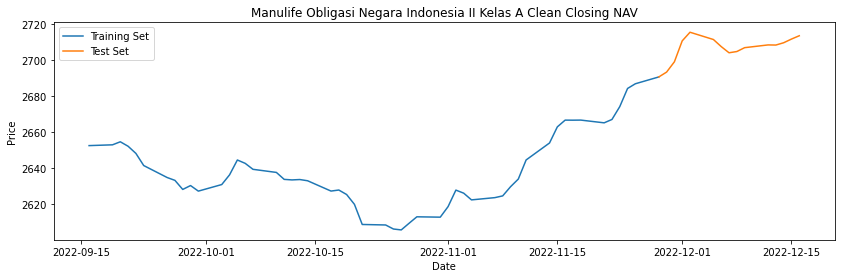

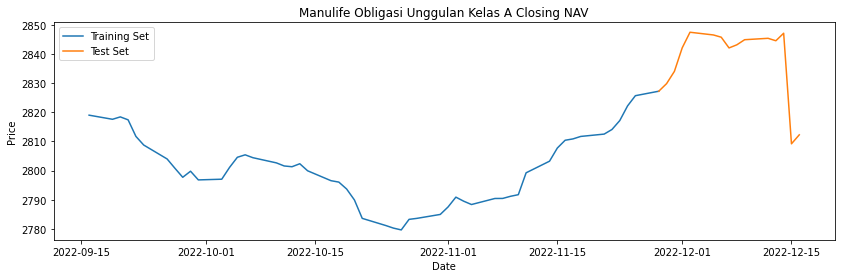

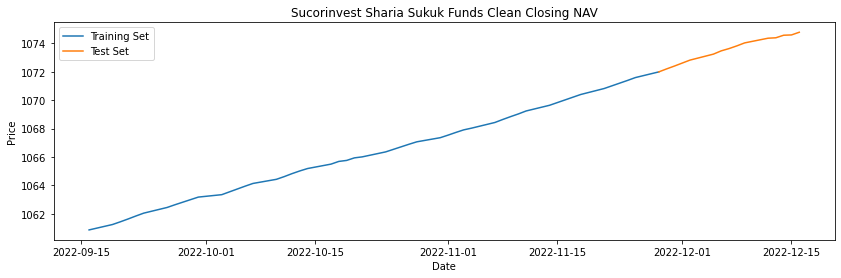

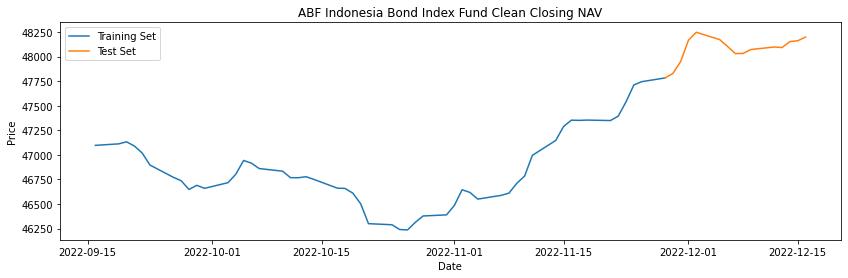

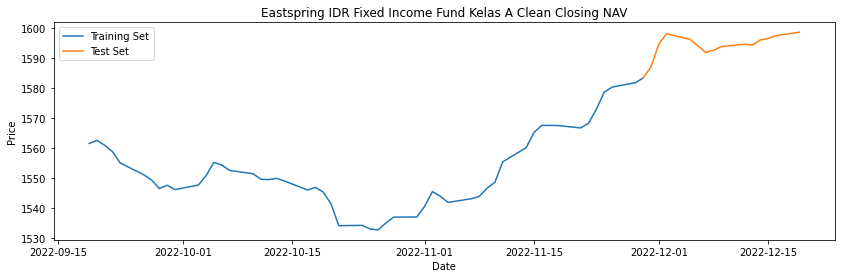

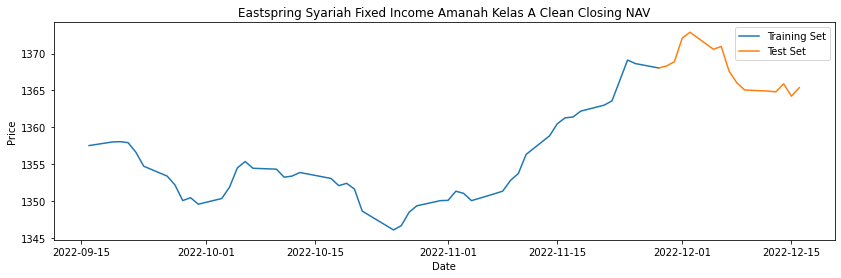

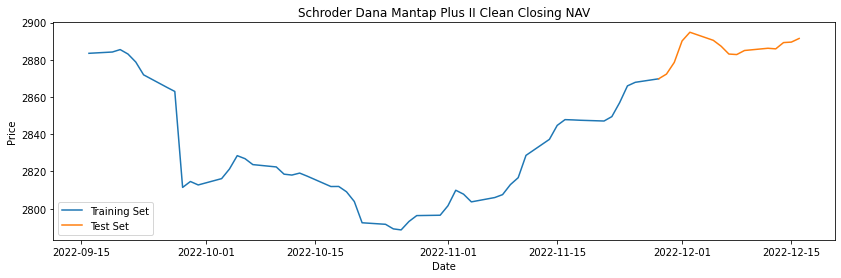

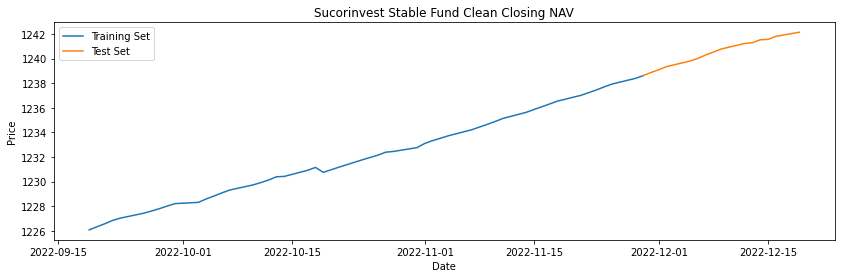

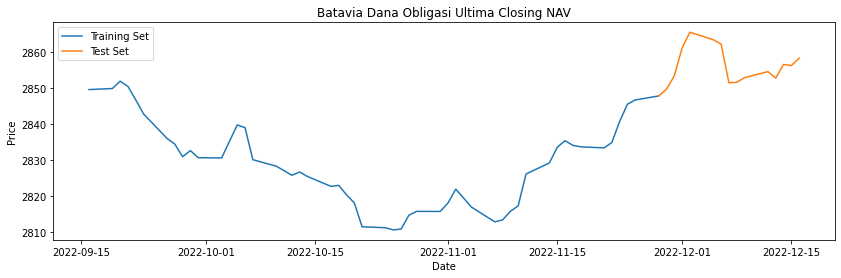

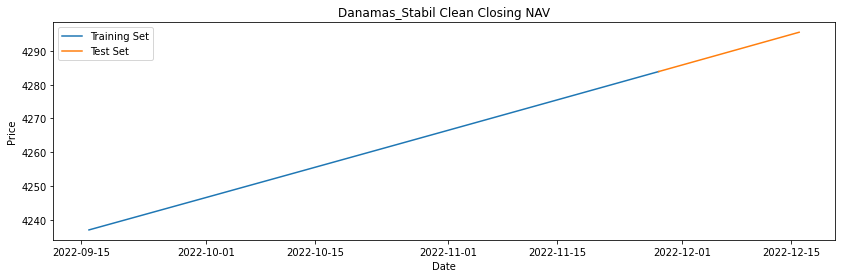

In [12]:
for i in dataset:
    plt.figure(figsize=(14,4))
    plt.plot(df_new[i]["train"])
    plt.plot(df_new[i]["test"])
    plt.ylabel("Price")
    plt.xlabel("Date")
    plt.legend(["Training Set", "Test Set"])
    plt.title(i + " Closing NAV")

## **Scaling**

In [13]:
# Scaling the training set
transform_train = {}
transform_test = {}
scaler = {}

for num, i in enumerate(dataset):
    sc = MinMaxScaler(feature_range=(0,1))
    a0 = np.array(df_new[i]["train"])
    a1 = np.array(df_new[i]["test"])
    a0 = a0.reshape(a0.shape[0],1)
    a1 = a1.reshape(a1.shape[0],1)
    transform_train[i] = sc.fit_transform(a0)
    transform_test[i] = sc.fit_transform(a1)
    scaler[i] = sc
    
del a0
del a1

In [14]:
transform_test["Manulife Obligasi Unggulan Kelas A"].shape

(15, 1)

In [15]:
trainset = {}
testset = {}
for j in dataset:
    trainset[j] = {}
    X_train = []
    y_train = []
    for i in range(1, 48):
        X_train.append(transform_train[j][i-1:i,0])
        y_train.append(transform_train[j][i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    trainset[j]["X"] = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
    trainset[j]["y"] = y_train
    
    testset[j] = {}
    X_test = []
    y_test = []    
    for i in range(1,14):
        X_test.append(transform_test[j][i-1:i,0])
        y_test.append(transform_test[j][i,0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    testset[j]["X"] = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 1))
    testset[j]["y"] = y_test

In [16]:
arr_buff = []
for i in dataset:
    buff = {}
    buff["X_train"] = trainset[i]["X"].shape
    buff["y_train"] = trainset[i]["y"].shape
    buff["X_test"] = testset[i]["X"].shape
    buff["y_test"] = testset[i]["y"].shape
    arr_buff.append(buff)

pd.DataFrame(arr_buff, index=dataset)

,X_train,y_train,X_test,y_test
Manulife Obligasi Negara Indonesia II Kelas A Clean,"(47, 1, 1)","(47,)","(13, 1, 1)","(13,)"
Manulife Obligasi Unggulan Kelas A,"(47, 1, 1)","(47,)","(13, 1, 1)","(13,)"
Sucorinvest Sharia Sukuk Funds Clean,"(47, 1, 1)","(47,)","(13, 1, 1)","(13,)"
ABF Indonesia Bond Index Fund Clean,"(47, 1, 1)","(47,)","(13, 1, 1)","(13,)"
Eastspring IDR Fixed Income Fund Kelas A Clean,"(47, 1, 1)","(47,)","(13, 1, 1)","(13,)"
Eastspring Syariah Fixed Income Amanah Kelas A Clean,"(47, 1, 1)","(47,)","(13, 1, 1)","(13,)"
Schroder Dana Mantap Plus II Clean,"(47, 1, 1)","(47,)","(13, 1, 1)","(13,)"
Sucorinvest Stable Fund Clean,"(47, 1, 1)","(47,)","(13, 1, 1)","(13,)"
Batavia Dana Obligasi Ultima,"(47, 1, 1)","(47,)","(13, 1, 1)","(13,)"
Danamas_Stabil Clean,"(47, 1, 1)","(47,)","(13, 1, 1)","(13,)"


## **Model**

In [17]:
from keras.callbacks import EarlyStopping

class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_mae') is not None and logs.get('val_mae') < 0.015:
      self.model.stop_training = True

earlystop = EarlyStopping(monitor='val_mae', patience=50)

In [18]:
%%time
# The LSTM architecture
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.1))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compiling the RNN
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, 
              metrics=["mae"], 
              loss=tf.keras.losses.Huber())

#Training Models
history = {}
for i in dataset:
    print("Train to", i)
    history[i] = model.fit(trainset[i]["X"], 
              trainset[i]["y"], 
              epochs=1000, 
              batch_size=8,
              validation_data=(testset[i]['X'], testset[i]['y']), 
              shuffle=False,
              callbacks=[Callback(), earlystop])

Streaming output truncated to the last 5000 lines.
6/6 [==============================] - 0s 17ms/step - loss: 0.0097 - mae: 0.1150 - val_loss: 0.0097 - val_mae: 0.1270
Epoch 221/1000
6/6 [==============================] - 0s 14ms/step - loss: 0.0085 - mae: 0.1102 - val_loss: 0.0097 - val_mae: 0.1269
Epoch 222/1000
6/6 [==============================] - 0s 17ms/step - loss: 0.0095 - mae: 0.1137 - val_loss: 0.0097 - val_mae: 0.1268
Epoch 223/1000
6/6 [==============================] - 0s 15ms/step - loss: 0.0097 - mae: 0.1158 - val_loss: 0.0097 - val_mae: 0.1267
Epoch 224/1000
6/6 [==============================] - 0s 18ms/step - loss: 0.0107 - mae: 0.1258 - val_loss: 0.0097 - val_mae: 0.1266
Epoch 225/1000
6/6 [==============================] - 0s 19ms/step - loss: 0.0102 - mae: 0.1174 - val_loss: 0.0096 - val_mae: 0.1265
Epoch 226/1000
6/6 [==============================] - 0s 17ms/step - loss: 0.0095 - mae: 0.1120 - val_loss: 0.0096 - val_mae: 0.1263
Epoch 227/1000
6/6 [=============

1/1 [==============================] - 0s 22ms/step


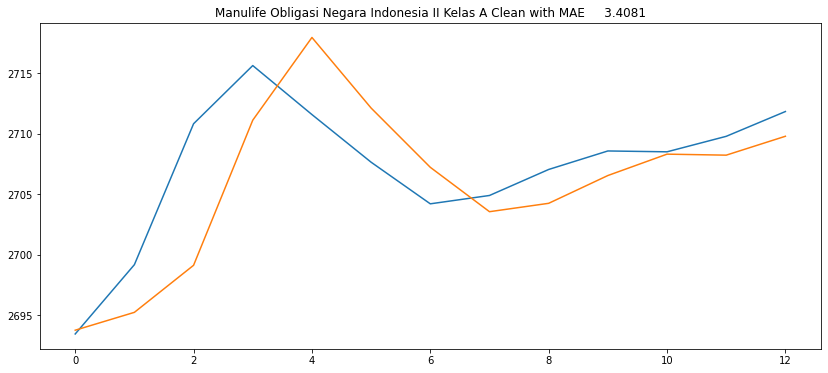

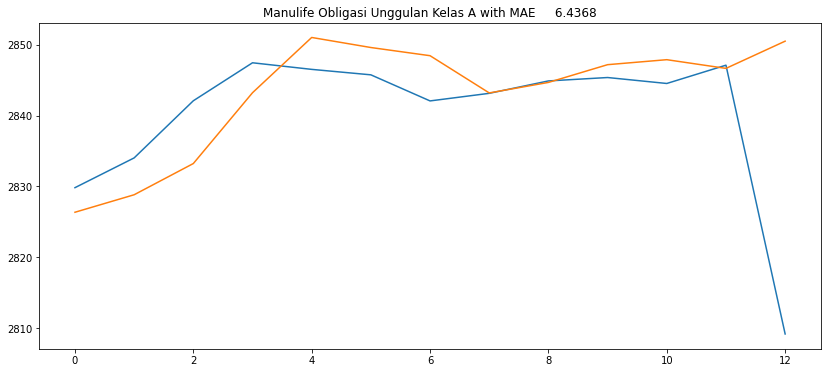

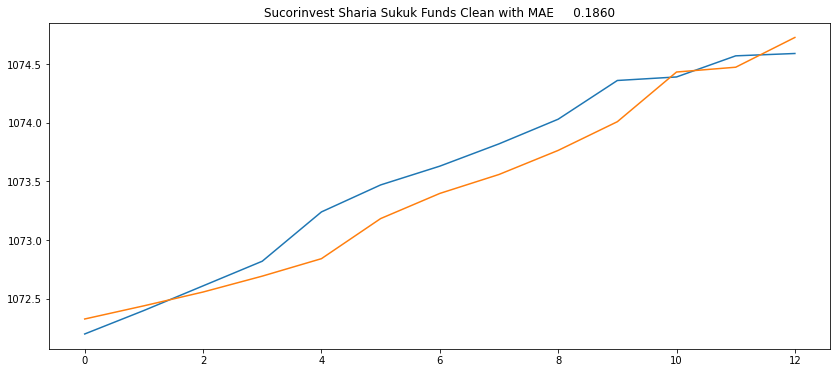

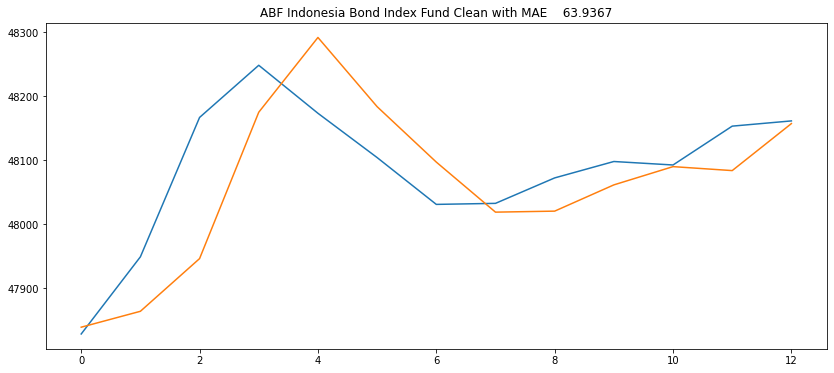

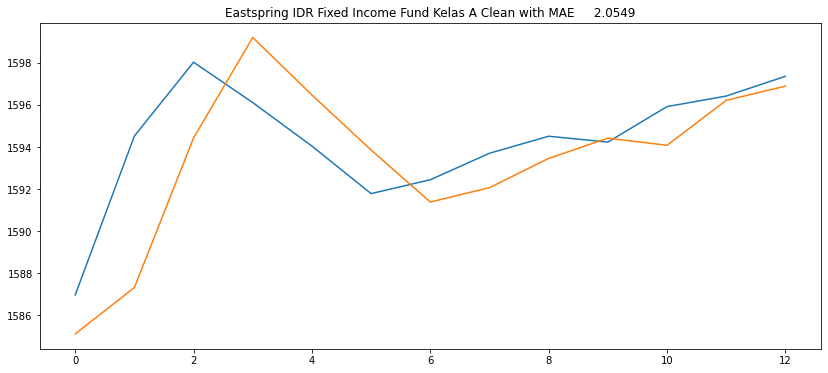

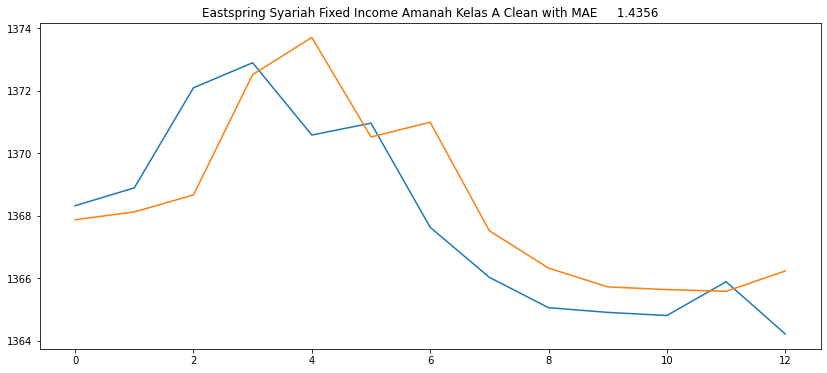

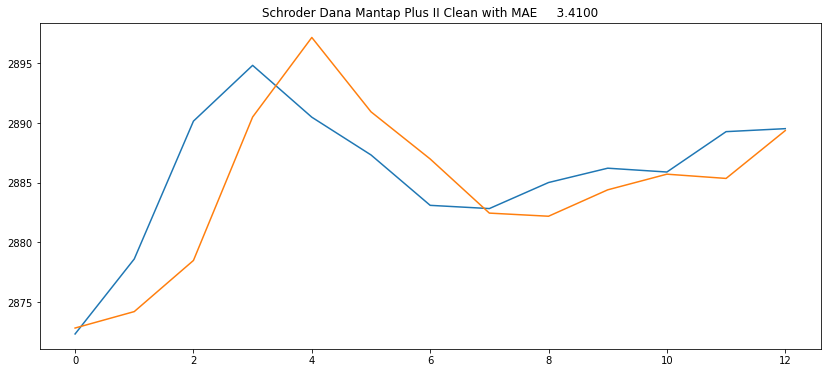

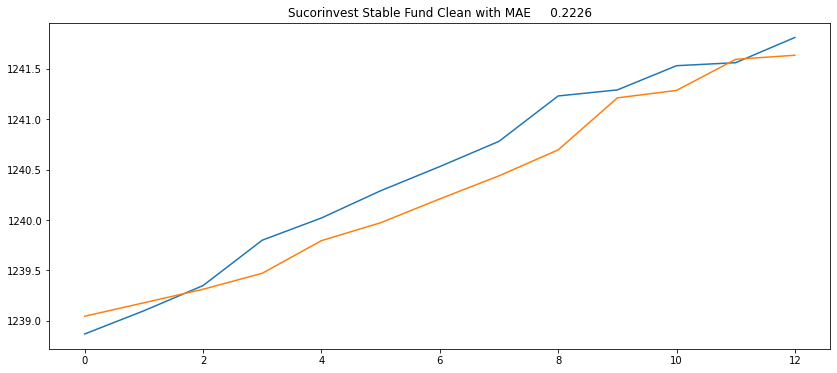

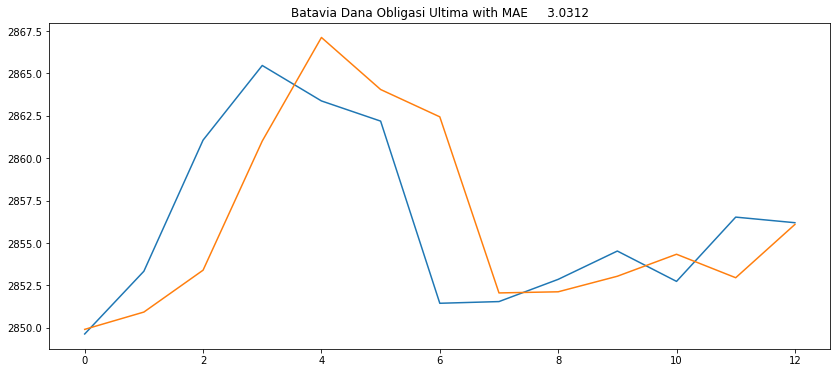

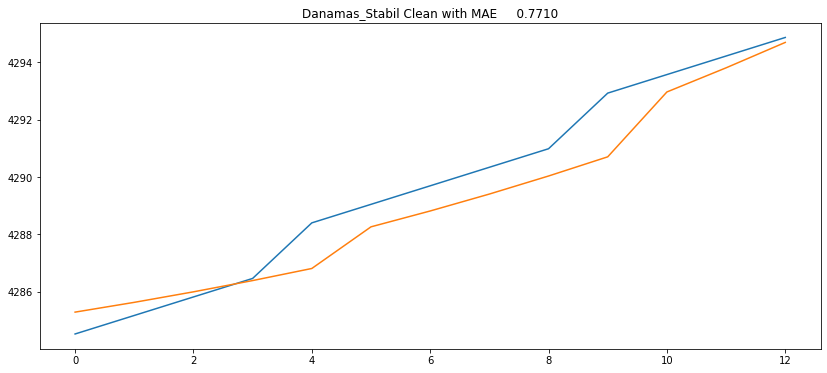

In [19]:
pred_result = {}
for i in dataset:
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    y_pred = scaler[i].inverse_transform(model.predict(testset[i]["X"]))
    MSE = mean_absolute_error(y_true, y_pred)
    pred_result[i] = {}
    pred_result[i]["True"] = y_true
    pred_result[i]["Pred"] = y_pred
    
    plt.figure(figsize=(14,6))
    plt.title("{} with MAE {:10.4f}".format(i,MSE))
    plt.plot(y_true)
    plt.plot(y_pred)

## **Model Evaluation**

Manulife Obligasi Negara Indonesia II Kelas A Clean - Loss & MAE


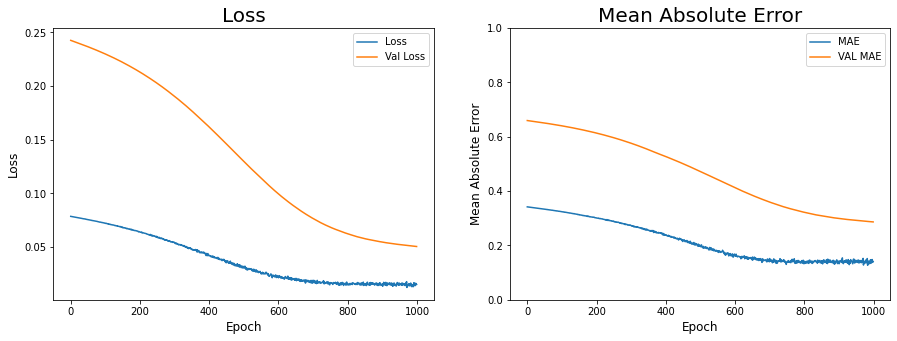

Manulife Obligasi Unggulan Kelas A - Loss & MAE


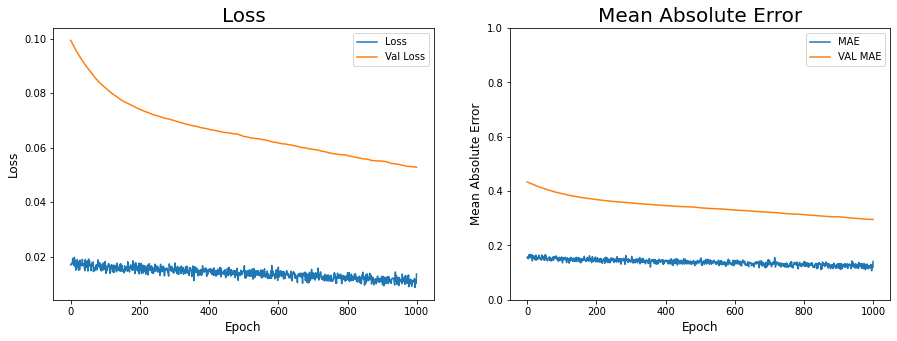

Sucorinvest Sharia Sukuk Funds Clean - Loss & MAE


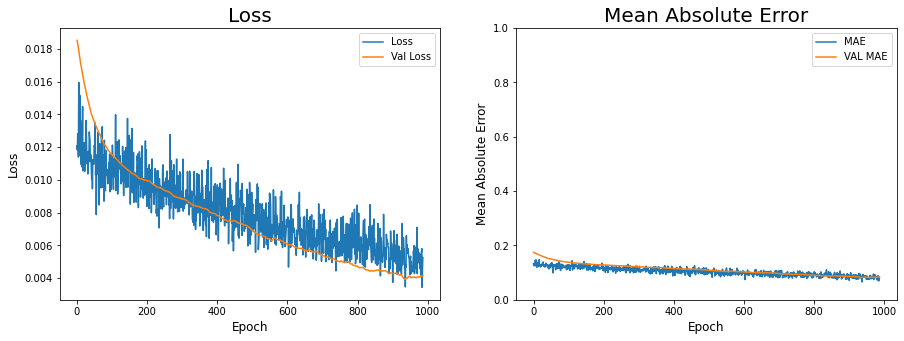

ABF Indonesia Bond Index Fund Clean - Loss & MAE


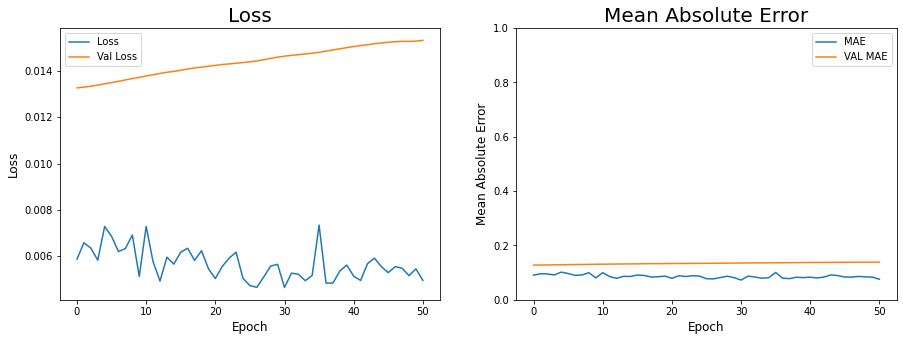

Eastspring IDR Fixed Income Fund Kelas A Clean - Loss & MAE


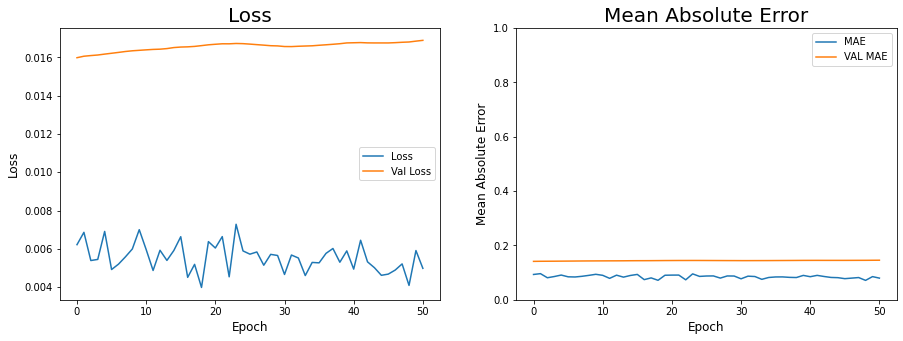

Eastspring Syariah Fixed Income Amanah Kelas A Clean - Loss & MAE


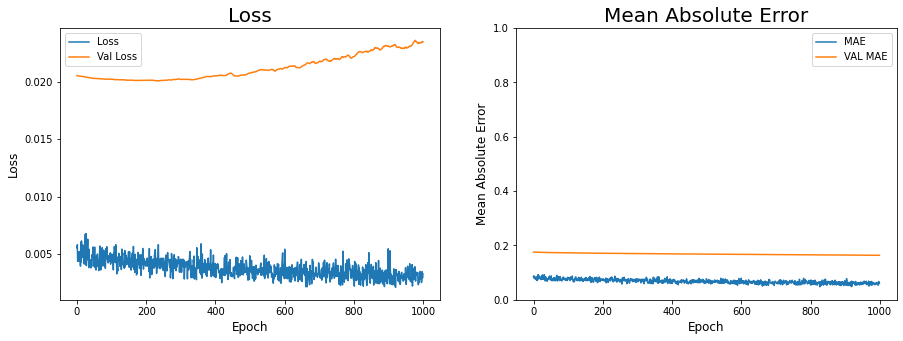

Schroder Dana Mantap Plus II Clean - Loss & MAE


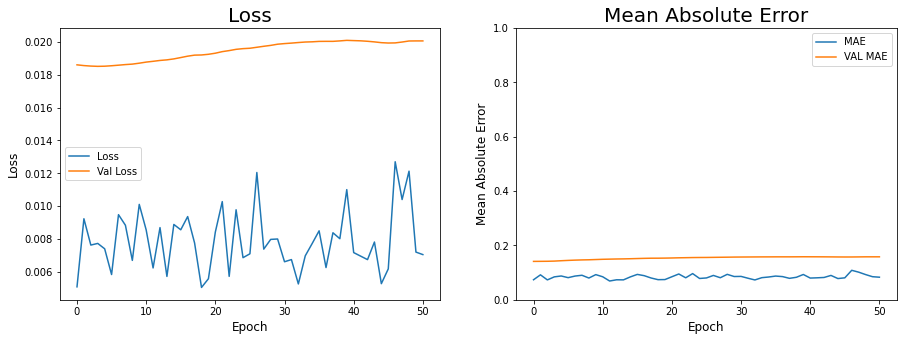

Sucorinvest Stable Fund Clean - Loss & MAE


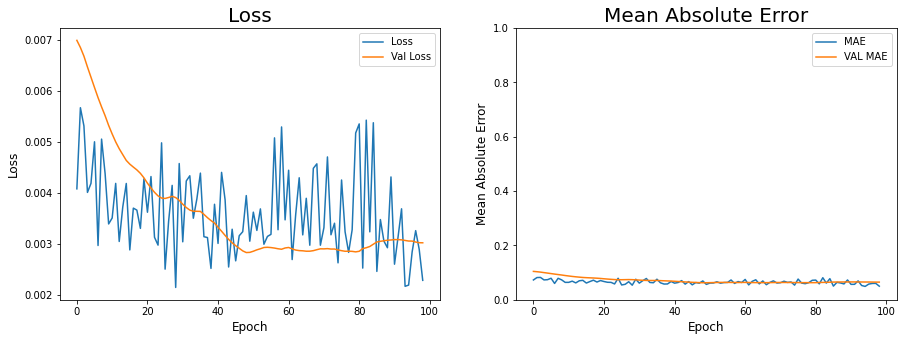

Batavia Dana Obligasi Ultima - Loss & MAE


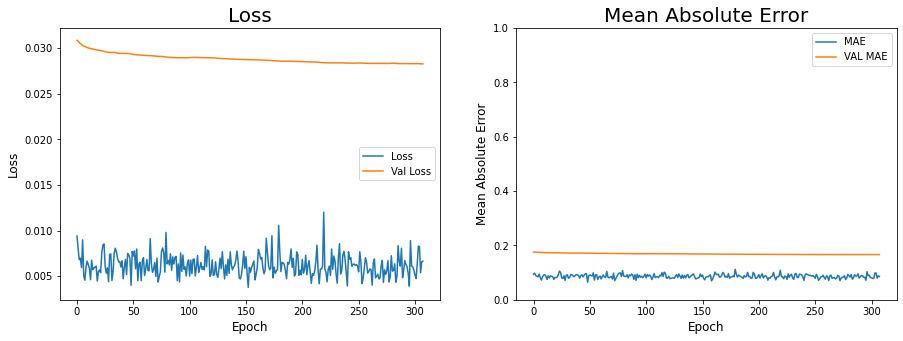

Danamas_Stabil Clean - Loss & MAE


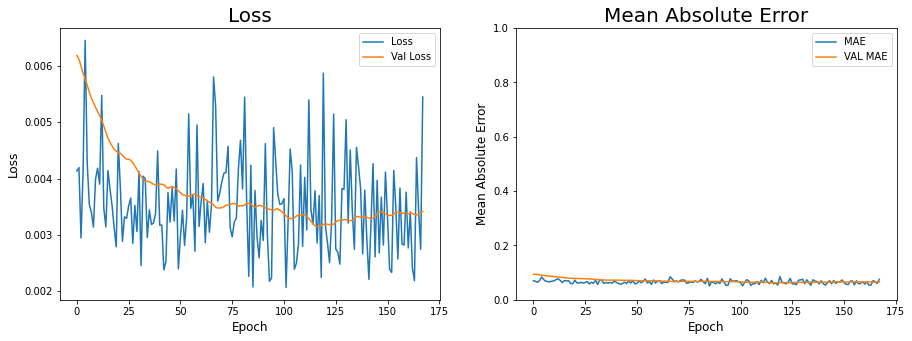

In [20]:
for i in dataset:
  print(i,"- Loss & MAE")
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
  ax1.plot(history[i].history['loss'])
  ax1.plot(history[i].history['val_loss'])
  ax1.legend(['Loss','Val Loss'])
  ax2.set_ylim(ymin=0, ymax=0.2)  
  ax1.set_xlabel('Epoch', fontsize=12)
  ax1.set_ylabel('Loss', fontsize=12)
  ax1.set_title('Loss', fontsize=20)

  ax2.plot(history[i].history['mae'])
  ax2.plot(history[i].history['val_mae'])
  ax2.legend(['MAE','VAL MAE'])
  ax2.set_ylim(ymin=0, ymax=1)
  ax2.set_xlabel('Epoch', fontsize=12)
  ax2.set_ylabel('Mean Absolute Error', fontsize=12)
  ax2.set_title('Mean Absolute Error', fontsize=20)
  plt.show()

In [28]:
mae_df = []
for i in dataset:
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    y_pred = scaler[i].inverse_transform(model.predict(testset[i]["X"]))
    MAE = mean_absolute_error(y_true, y_pred)
    mae_df.append(MAE)

a = pd.DataFrame(mae_df, columns=['MAE'], index=dataset)
b = a['MAE'].mean()


print(f'Average from all MAE : {b}')
a

1/1 [==============================] - 0s 25ms/step
Average from all MAE : 8.489288311298127


,MAE
Manulife Obligasi Negara Indonesia II Kelas A Clean,3.408149
Manulife Obligasi Unggulan Kelas A,6.436780
Sucorinvest Sharia Sukuk Funds Clean,0.186037
ABF Indonesia Bond Index Fund Clean,63.936715
Eastspring IDR Fixed Income Fund Kelas A Clean,2.054917
Eastspring Syariah Fixed Income Amanah Kelas A Clean,1.435581
Schroder Dana Mantap Plus II Clean,3.409959
Sucorinvest Stable Fund Clean,0.222555
Batavia Dana Obligasi Ultima,3.031209
Danamas_Stabil Clean,0.770982


In [21]:
from datetime import datetime 
win = 2
out = []
def forecast(day, x):
  data_inf = df[x]['value'].copy()
  for j in range(day):
    X = np.array(data_inf[-2:])
    X = X.reshape(X.shape[0],1)  
    X_scaled = scaler[x].transform(X)
    X_scaled = np.reshape(X_scaled, (X_scaled.shape[0], 1, 1))
    new_idx = datetime(data_inf.index.year[-1], data_inf.index.month[-1], data_inf.index.day[-1]+1)
    xvalue = scaler[x].inverse_transform(model.predict(X_scaled))
    data_inf[new_idx] = np.round(xvalue[1][0])
  return data_inf

## **Next Day**

In [22]:
predictors = {}
npred = {}
for i, val in enumerate(dataset):
  npred = {}
  print(i,"-",val)
  npred = forecast(2, val)
  print(npred[-3:])

0 - Manulife Obligasi Negara Indonesia II Kelas A Clean
1/1 [==============================] - 0s 21ms/step
date
2022-12-16    2713.7
2022-12-17    2715.0
2022-12-18    2717.0
Name: value, dtype: float64
1 - Manulife Obligasi Unggulan Kelas A
1/1 [==============================] - 0s 28ms/step
date
2022-12-16    2812.27
2022-12-17    2815.00
2022-12-18    2817.00
Name: value, dtype: float64
2 - Sucorinvest Sharia Sukuk Funds Clean
1/1 [==============================] - 0s 23ms/step
date
2022-12-16    1074.78
2022-12-17    1075.00
2022-12-18    1075.00
Name: value, dtype: float64
3 - ABF Indonesia Bond Index Fund Clean
1/1 [==============================] - 0s 21ms/step
date
2022-12-16    48199.3099
2022-12-17    48219.0000
2022-12-18    48248.0000
Name: value, dtype: float64
4 - Eastspring IDR Fixed Income Fund Kelas A Clean
1/1 [==============================] - 0s 23ms/step
date
2022-12-19    1598.5
2022-12-20    1600.0
2022-12-21    1602.0
Name: value, dtype: float64
5 - Eastspring 

In [23]:
label = []
percent = []
mf = []
values = []

for i, val in enumerate(dataset):
  npred = {}
  npred = forecast(1, val)

  if npred[-2] <= npred[-1]:
    xy = npred[-1] - npred[-2]
    per = round(xy/npred[-2]*100,2)
    percent.append(per)
    label.append(1)
    mf.append(val)
    values.append(npred[-1])
  else:
    xy = npred[-1] - npred[-2]
    per = round(xy/npred[-2]*100,2)
    percent.append(per)
    label.append(0)
    mf.append(val)
    values.append(npred[-1])

1/1 [==============================] - 0s 21ms/step


In [24]:
outputs = {
    'Mutual_Funds' : mf,
    'Predicted_NAV' : values,
    'Percentage' : percent,
    'Label' : label
}

In [25]:
final_medrisk = pd.DataFrame(outputs)
final_medrisk

,Mutual_Funds,Predicted_NAV,Percentage,Label
0,Manulife Obligasi Negara Indonesia II Kelas A ...,2715.0,0.05,1
1,Manulife Obligasi Unggulan Kelas A,2815.0,0.10,1
2,Sucorinvest Sharia Sukuk Funds Clean,1075.0,0.02,1
3,ABF Indonesia Bond Index Fund Clean,48219.0,0.04,1
4,Eastspring IDR Fixed Income Fund Kelas A Clean,1600.0,0.09,1
5,Eastspring Syariah Fixed Income Amanah Kelas A...,1366.0,0.05,1
6,Schroder Dana Mantap Plus II Clean,2892.0,0.02,1
7,Sucorinvest Stable Fund Clean,1242.0,-0.01,0
8,Batavia Dana Obligasi Ultima,2858.0,-0.01,0
9,Danamas_Stabil Clean,4297.0,0.03,1


In [26]:
final_medrisk.to_csv('final_medrisk.csv')

In [27]:
from google.colab import files
files.download('final_medrisk.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>